In [11]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import wandb
import pytorch_lightning as pl
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression
from source.wrappers import ForwardWrapper
import os
import seaborn as sns

In [14]:
from source.tasks import DeepSurv

In [21]:
RESULTS_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities'
DATA_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
EVALUATION_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation'

In [6]:
import wandb

## Helpful functions

In [128]:
def load_attribute_details(experiment_id):
    dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
    path = f'{dir}/{experiment_id}_attribute_details.csv'
    details_df = pd.read_csv(path)
    return details_df, path

# TODO: this works if the second tag is the experiment identifier
def load_details(run):
    dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
    try:
        path = f'{dir}/{run.tags[0]}_attribute_details.csv'
        details_df = pd.read_csv(path)
    except:
        path = f'{dir}/{run.tags[1]}_attribute_details.csv'
        details_df = pd.read_csv(path)
    print(f'reading {path}')
    return details_df, path

def output_diff(model, orig_features, resampled_features):
    orig_output, *_ = model(orig_features)
    resampled_output, *_ = model(resampled_features)
    with torch.no_grad():
        diff = torch.sub(orig_output, resampled_output)
    return diff.detach().numpy()

# CREATE TUPLES FOR MODEL DIFF

def col2numpy(df, colname):
    """
    convert a dataframe column to a numpy array
    :param df: dataframe
    :param colname: column name to convert to numpy array
    :return:
    """
    vals = df.loc[:, colname].values.tolist()
    vals_numpy = np.array([np.array(eval(row)) for row in vals])
    return vals_numpy

def clip_norm2d(array, tail):
    """
    clips and normalizes the array to the range of [-1, 1]
    :param array: array to be normalized
    :return: normalized array
    """
    array_norm = np.zeros((array.shape))
    c_array = np.zeros((array.shape))
    for i in range(array.shape[0]):
        column = array[i, :]
        outliers = np.percentile(column, [tail, 100-tail])
        clipped_array = np.clip(column, *outliers)
        col_norm = clipped_array / abs(clipped_array).max()
        #TODO: !!!!!FIX THIS!!!!
        array_norm[i, :] = col_norm
        c_array[i, :] = clipped_array
    return  array_norm, c_array

def clip_norm1d(array, tail):
    """
    clips and normalizes the array to the range of [-1, 1]
    :param array:  array to be normalized
    :return: normalized array
    """
    outliers = np.percentile(array, [tail, 100-tail])
    clipped_array = np.clip(array, *outliers)
    array_norm = clipped_array / abs(clipped_array).max()
    return array_norm, clipped_array

def load_attributions(run, method, n_features=5):
    attribution_list = [np.genfromtxt(run.config[f'{method}_feature{idx}_path'], delimiter=',') for idx in range(n_features)]
    return attribution_list

def reject_outliers(data, m = 150.0):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    max = data[s<m].max()
    min = data[s<m].min()
    out = np.where(s<m, data, np.where(data>0, max, min))
    return out

def clip2d(array):
    clipped_array = np.zeros((array.shape))
    for i in range(array.shape[0]):
        clipped_array[i, :] = reject_outliers(array[i, :])
    return clipped_array

## Create resampling dataframe

In [129]:
def create_resampling_df(experiment_id, n_resampling=100, n_features=6):
    """
    Modify the original resampling dataframe to create per-feature resampling df with resampling differences
    :param experiment_id: experiment identifier
    :return: None -> saves resampling dataframe
    """
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})
    run = runs[0]
    details_df, path = load_attribute_details(experiment_id)

    modified_attributes = [f'noise{idx}' for idx in range(n_features)]
    for idx in range(n_features):
        df = details_df[details_df.modified_attribute == f'noise{idx}']
        colnames = [f'feature{idx}_intervention{n}' for n in range(n_resampling)]

        # TODO
        rcolnames = [f'feature1_intervention{n}' for n in range(n_resampling)]
        rintervention_df = df.loc[:, rcolnames]
        rintervention_df['intervention'] = rintervention_df.values.tolist()

        intervention_df = df.loc[:, colnames]
        intervention_df['intervention'] = intervention_df.values.tolist()
        resampling_df = pd.DataFrame({f'feature{idx}_resampling': intervention_df.intervention,
                                      'feature1_rresampling': rintervention_df.intervention,
                                      f'feature{idx}_orig': df[f'feature{idx}_orig'],
                                      'time_orig': df.time_orig,
                                      'event_orig': df.event_orig})
        # return resampling_df, df
        for n in range(n_features):
            resampling_df[f'feature{n}_orig'] = df[f'feature{n}_orig']

        orig_vals = resampling_df.loc[:, f'feature{idx}_orig'].values
        resamp_vals = resampling_df.loc[:, f'feature{idx}_resampling'].values.tolist()
        resamp_vals_numpy=np.array([np.array(row) for row in resamp_vals])
        orig_vals_array = np.array([[val] * n_resampling for val in orig_vals])
        resampling_df.loc[:, 'resampling_diff'] = np.subtract(orig_vals_array, resamp_vals_numpy).tolist()

        # exp_id_trunc = experiment_id[:-2]
        resampling_df.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv')
        print(f' wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv')

In [130]:
import pandas as pd

In [131]:
experiment_id = 'linear_revised_3'
dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
path = f'{dir}/{experiment_id}_attribute_details.csv'
details_df = pd.read_csv(path)
details_df

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [11]:
experiment_id = 'linear_revised_2'
path = f'{dir}/{experiment_id}_attribute_details.csv'
details_df.to_csv(path)

In [12]:
experiment_id = 'linear_revised_1'
path = f'{dir}/{experiment_id}_attribute_details.csv'
details_df.to_csv(path)

In [8]:
experiment_id = 'linear_cc_2'
dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
path = f'{dir}/{experiment_id}_attribute_details.csv'
details_df = pd.read_csv(path)
details_df

,Unnamed: 0,modified_attribute,hidden_noise_orig,hidden_variable_orig,noise0_orig,feature0_orig,noise1_orig,feature1_orig,noise2_orig,feature2_orig,...,feature2_intervention99,noise3_intervention99,feature3_intervention99,noise4_intervention99,feature4_intervention99,noise5_intervention99,feature5_intervention99,hazard_orig,event_orig,time_orig
0,0,noise0,0.017653,15.170813,0.011412,-5.754580,0.007154,2.783774,-0.003790,28.125882,...,28.125882,0.005072,10.572549,0.006910,11.401268,0.008446,21.563360,-1.300986,1.0,1.089189
1,1,noise0,0.003746,33.160414,-0.010304,-0.704998,-0.002038,13.115363,0.007668,19.196534,...,19.196534,-0.009310,39.078987,-0.000049,30.452957,-0.004090,40.251068,2.325772,1.0,0.720420
2,2,noise0,0.011308,-0.482314,0.015938,-3.644598,0.000776,7.047436,0.003100,28.492065,...,28.492065,0.009895,4.519744,0.007404,15.645039,0.001762,-3.974598,-0.366263,1.0,1.006227
3,3,noise0,0.004596,10.186954,-0.001307,-0.089773,0.002534,14.878691,0.002229,65.577781,...,65.577781,-0.000330,7.504822,-0.006591,5.436543,0.000304,8.672189,1.356092,0.0,0.000000
4,4,noise0,-0.018512,19.295038,-0.003135,-0.001321,-0.001156,1.862547,0.012500,11.059373,...,11.059373,0.002759,16.062726,0.001777,27.328293,-0.001029,22.382198,0.578517,1.0,0.907931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30095,30095,noise5,-0.007962,19.542572,0.008811,7.215381,0.000364,4.742604,0.009107,20.812874,...,20.812874,-0.009933,18.853302,-0.006773,8.585719,-0.013457,10.977047,2.693682,0.0,0.000000
30096,30096,noise5,0.012465,20.421069,-0.001468,-9.168749,0.011004,5.229583,-0.009520,22.611479,...,22.611479,-0.013790,17.161507,0.011066,12.387845,0.000368,22.085092,-1.764510,0.0,0.000000
30097,30097,noise5,-0.000863,3.068828,0.009862,-2.223355,-0.011269,2.869682,-0.000093,62.228436,...,62.228436,-0.007349,4.285997,0.005296,-5.023684,0.000035,10.863646,-1.058377,0.0,0.902313
30098,30098,noise5,-0.008722,18.197236,0.018369,7.297602,-0.004952,1.461313,0.002524,8.249011,...,8.249011,-0.001455,16.865053,0.008268,21.020876,-0.011333,17.230074,2.520339,0.0,0.000000


In [ ]:
create_resampling_df(experiment_id='linear_cc_1', n_resampling=100, n_features=4)

# Change Slope Calculation

In [132]:
def calculate_change_slope(experiment_id, n_features=5):
    """
    Calculates change slope for each run
    :param experiment_id: experiment identifier
    :return: None -> saves the change slope per run
    """
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})
    print(len(runs))
    for run in runs:
        for idx in range(n_features):
            resampling_df = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv', index_col=0)
            print(f'read /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_feature{idx}.csv')
            intervention_df = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_attribute_details.csv')
            intervention_df = intervention_df[intervention_df['modified_attribute']==f'noise{idx}']
            model = DeepSurv.load_from_checkpoint(run.config['checkpoint_path'])

            # create orig and resampling tensors
            orig_features = [f'feature{idx}_orig' for idx in range(n_features)]
            orig_tensor = torch.Tensor(resampling_df[orig_features].to_numpy(dtype='float64'))
            resamp_tensors = []
            resamp_vals = col2numpy(resampling_df, f'feature{idx}_resampling')
            for i_intervention in range(100):
                resamp_features = [f'feature{n}_intervention{i_intervention}' for n in range(n_features)]
                resamp_tensors.append(torch.Tensor(intervention_df.loc[:, resamp_features].to_numpy(dtype='float64')))

            # calculate model outputs
            orig_output = model(orig_tensor)[0].detach().numpy()
            resamp_outputs = None
            for i in range(resamp_vals.shape[1]):
                resamp_output = model(resamp_tensors[i])[0].detach().numpy()
                resamp_outputs = resamp_output if resamp_outputs is None else np.concatenate((resamp_outputs, resamp_output), axis=1)

            # calculate change_slope
            model_diff = np.subtract(orig_output, resamp_outputs)
            resampling_diff = col2numpy(resampling_df, 'resampling_diff')
            change_slope = np.true_divide(model_diff, resampling_diff)
            clipped_mean_cs = np.mean(clip2d(change_slope), axis=1)
            mean_cs = np.mean(change_slope, axis=1)
            median_cs = np.median(change_slope, axis=1)

            # save values in dataframe
            resampling_df.loc[:, 'orig_output'] = orig_output
            resampling_df.loc[:, 'resamp_output'] = resamp_outputs.tolist()
            resampling_df.loc[:, 'model_diff'] = model_diff.tolist()
            resampling_df.loc[:, 'change_slope'] = change_slope.tolist()
            resampling_df.loc[:, 'mean_cs'] = mean_cs
            resampling_df.loc[:, 'clipped_mean_cs'] = clipped_mean_cs
            resampling_df.loc[:, 'median_cs'] = median_cs
            methods = ['FeaturePermutation',
                       'IntegratedGradients',
                       'InputxGradient',
                       'Lime',
                       'KernelExplainer',
                       'DeepExplainer']


            for method in methods:
                attribution_list = load_attributions(run, method, n_features=n_features)
                resampling_df.loc[:, f'{method}_feature{idx}'] = attribution_list[idx].tolist()

            # Save dataframes
            EVALUATION_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation'
            if not os.path.exists(f'{EVALUATION_DIR}/{experiment_id}'):
                os.mkdir(f'{EVALUATION_DIR}/{experiment_id}')

            if not os.path.exists(f'{EVALUATION_DIR}/{experiment_id}/change_slope'):
                os.mkdir(f'{EVALUATION_DIR}/{experiment_id}/change_slope')

            # very whack
            seed = int(run.config['Lime_feature0_path'].split('_')[-1][:-4])

            resampling_df.to_csv(f'{EVALUATION_DIR}/{experiment_id}/change_slope/feature{idx}_{seed}.csv')
            print(f'Wrote {EVALUATION_DIR}/{experiment_id}/change_slope/feature{idx}_{seed}.csv')

In [ ]:
calculate_change_slope('linear_cc_1', n_features=4)

In [ ]:
calculate_change_slope('linear_cc_2', n_features=5)

In [ ]:
calculate_change_slope('linear_cc_3', n_features=6)

In [133]:
def reject_outliers(data, m = 150.0):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    max = data[s<m].max()
    min = data[s<m].min()
    out = np.where(s<m, data, np.where(data>0, max, min))
    return out

## Calculate Change Slope

Now that we have the resampling dataframe with resampling_diff, orig points & resampling points we can calculate change_slope for each seed

In [134]:
def calculate_mean_error(experiment_id, n_features=5):
    for idx in range(n_features):
        feature = f'feature{idx}'
        dir = os.listdir(f'{EVALUATION_DIR}/{experiment_id}/change_slope/')
        paths = []
        for filename in dir:
            featurename = filename.split('_')[0]
            if featurename == feature:
                paths.append(f'{EVALUATION_DIR}/{experiment_id}/change_slope/{filename}')

        mean_change_slopes = None
        median_change_slopes = None
        unclipped_mean_change_slopes = None
        for path in paths:
            df = pd.read_csv(path, index_col=0)
            unclipped_mean_change_slope = df.mean_cs.to_numpy().reshape(-1, 1)
            unclipped_mean_change_slopes = unclipped_mean_change_slope if unclipped_mean_change_slopes is None else np.concatenate((unclipped_mean_change_slopes, unclipped_mean_change_slope), axis=1)
            # mean change slope
            mean_change_slope = df.clipped_mean_cs.to_numpy().reshape(-1, 1)
            mean_change_slopes = mean_change_slope if mean_change_slopes is None else np.concatenate((mean_change_slopes, mean_change_slope), axis=1)
            # median change slope
            median_change_slope = df.median_cs.to_numpy().reshape(-1, 1)
            median_change_slopes = median_change_slope if median_change_slopes is None else np.concatenate((median_change_slopes, median_change_slope), axis=1)

        unclipped_mean_cs_norm = unclipped_mean_change_slopes / abs(unclipped_mean_change_slopes).max()
        mean_cs_norm = mean_change_slopes / abs(mean_change_slopes).max()
        median_cs_norm = median_change_slopes / abs(median_change_slopes).max()

        methods = ['FeaturePermutation',
                   'IntegratedGradients',
                   'InputxGradient',
                   'Lime',
                   'KernelExplainer',
                   'DeepExplainer']

        for method in methods:
            attrs = None
            for path in paths:
                # normalize per seed & aggregate runs per experiment
                df = pd.read_csv(path, index_col=0)
                attr = col2numpy(df, f'{method}_feature{idx}')
                attr = attr / abs(attr).max()
                attr = attr[:, idx].reshape(-1, 1)
                attrs = attr if attrs is None else np.concatenate((attrs, attr), axis=1)

            unclipped_absolute_error = np.absolute(unclipped_mean_cs_norm - attrs)
            absolute_error = np.absolute(mean_cs_norm - attrs)
            median_absolute_error = np.absolute(median_cs_norm - attrs)
            mae = np.mean(absolute_error, axis=1)
            unclipped_mae = np.mean(unclipped_absolute_error, axis=1)
            median_mae = np.mean(median_absolute_error, axis=1)
            orig_features = [f'feature{i}_orig' for i in range(n_features)]
            fulldf = df.loc[:, orig_features]
            fulldf.loc[:, 'absolute_error'] = absolute_error.tolist()
            fulldf.loc[:, 'unclipped_absolute_error'] = unclipped_absolute_error.tolist()
            fulldf.loc[:, 'median_absolute_error'] = median_absolute_error.tolist()
            fulldf.loc[:, 'unclipped_MAE'] = unclipped_mae
            fulldf.loc[:, 'MAE'] = mae
            fulldf.loc[:, 'median_MAE'] = median_mae
            fulldf.loc[:, 'method'] = method
            fulldf.to_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv')
            print(f'wrote {EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv')

In [ ]:
calculate_mean_error('linear_cc_1', n_features=4)

In [ ]:
calculate_mean_error('linear_cc_2', n_features=5)

In [ ]:
calculate_mean_error('linear_cc_3', n_features=6)

In [ ]:
calculate_mean_error('lognormal_cc_1', n_features=4)

In [ ]:
calculate_mean_error('lognormal_cc_2', n_features=5)

In [ ]:
calculate_mean_error('lognormal_cc_3', n_features=6)

In [150]:
methods = ['FeaturePermutation',
           'IntegratedGradients',
           'InputxGradient',
           'Lime',
           'KernelExplainer',
           'DeepExplainer']

methods_keywords = ['feature_permutation',
                    'integrated_gradients',
                    'input_x_gradient',
                    'lime',
                    'kernel_explainer',
                    'deep_explainer']

def load_mean_errors(experiment_id, idx):
    error_dict = dict(feature_permutation = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_FeaturePermutation.csv', index_col=0),
                      integrated_gradients = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_IntegratedGradients.csv', index_col=0),
                      input_x_gradient = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_InputxGradient.csv', index_col=0),
                      lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_Lime.csv', index_col=0),
                      kernel_explainer = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_KernelExplainer.csv', index_col=0),
                      deep_explainer = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_DeepExplainer.csv', index_col=0))
    return error_dict

def load_flattened_errors(experiment_id, idx):
    error_dict = dict(feature_permutation = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}_FeaturePermutation.csv', index_col=0),
                      integrated_gradients = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}_IntegratedGradients.csv', index_col=0),
                      input_x_gradient = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}_InputxGradient.csv', index_col=0),
                      lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}_Lime.csv', index_col=0),
                      kernel_explainer = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}_KernelExplainer.csv', index_col=0),
                      deep_explainer = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}_DeepExplainer.csv', index_col=0))
    return error_dict

In [5]:
import pandas as pd

In [136]:
def concat_dataframe(experiment_id, n_features):
    for idx in range(n_features):
        simpsons_dict = load_mean_errors(experiment_id, idx=idx)
        concat_df = pd.concat(list(simpsons_dict.values()))
        concat_df.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature{idx}.csv')
        print(f' wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature{idx}.csv')

In [158]:
def concat_flattened_dataframe(experiment_id, n_features, idx):
    simpsons_dict = load_flattened_errors(experiment_id, idx=idx)
    concat_df = pd.concat(list(simpsons_dict.values()))
    concat_df.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/FlattenedError_feature{idx}.csv')
    print(f' wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/FlattenedError_feature{idx}.csv')

In [273]:
ds1 = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_1/ConcatMeanError_feature3.csv')
ds1.loc[:, 'n_correlations'] = 0
# ds2 = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_2/ConcatMeanError_feature3.csv')
# ds2.loc[:, 'n_correlations'] = 2
ds3 = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_3/ConcatMeanError_feature3.csv')
ds3.loc[:, 'n_correlations'] = 3
fulldf = pd.concat([ds1, ds3], ignore_index=True)

Text(0.5, 1.05, 'Delta to LPG With Increasing Number of Correlations')

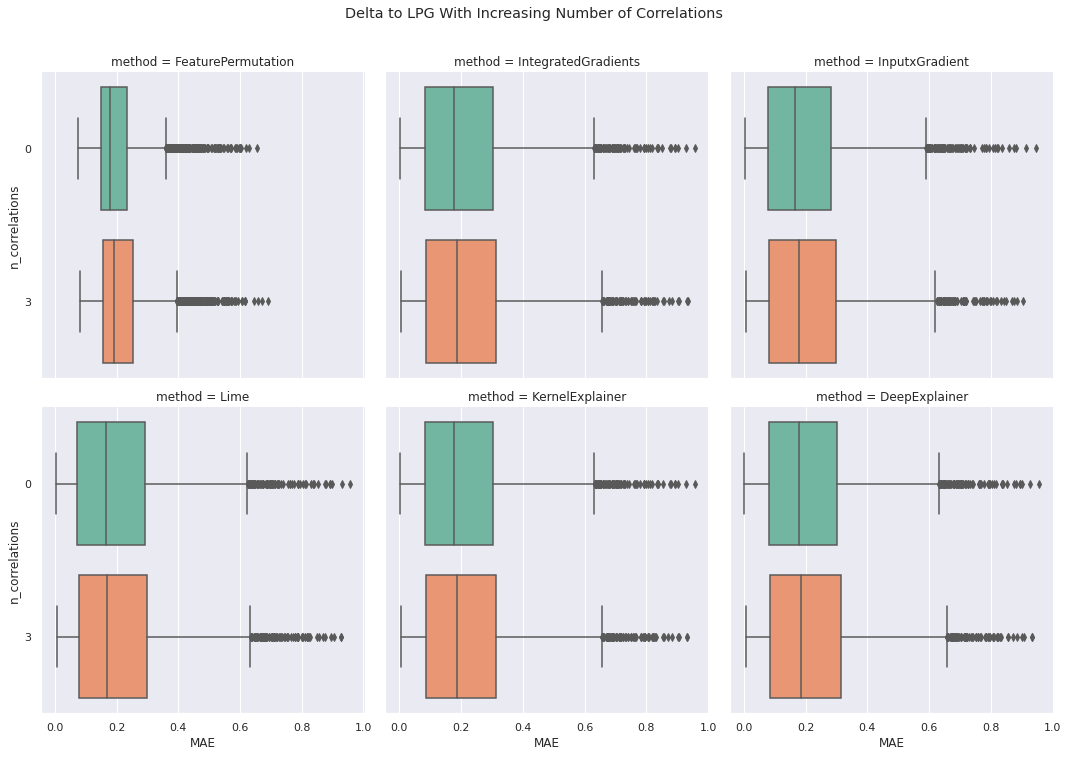

In [276]:
sns.set(rc={'figure.figsize':(20, 9)})
ax = sns.catplot(
    data=fulldf, x='MAE', y='n_correlations', orient='h',
    col='method', kind='box', col_wrap=3, palette='Set2', margin_titles=True,
)
ax.fig.suptitle('Delta to LPG With Increasing Number of Correlations', y=1.05)

In [289]:
for method in methods:
    df = fulldf[fulldf['method'] == method]
    df.to_csv(f'{EVALUATION_DIR}/n_corr_comparison_{method}.csv')

In [288]:
fulldf

,Unnamed: 0,feature0_orig,feature1_orig,feature2_orig,feature3_orig,absolute_error,unclipped_absolute_error,median_absolute_error,unclipped_MAE,MAE,median_MAE,method,n_correlations
0,15100,-1.600297,1.160718,22.934888,-0.532154,"[0.09172596234327546, 0.015702030811906464, 0....","[0.05543480041362537, 0.023448144450486142, 0....","[0.3132644764224376, 0.2567213685464225, 0.568...",0.252804,0.282790,0.488999,FeaturePermutation,0
1,15101,7.267520,12.236927,82.639847,19.382078,"[0.24175094703171573, 0.2509529520522138, 0.05...","[0.20077318926450397, 0.28044570008486946, 0.0...","[0.35654783735498286, 0.13696595597870156, 0.2...",0.213774,0.202387,0.195956,FeaturePermutation,0
2,15102,-6.902593,9.960215,40.172565,21.595461,"[0.3413381406980677, 0.1819063714061115, 0.294...","[0.3727704347603857, 0.1461731848186255, 0.330...","[0.14216014955604872, 0.4133267121027949, 0.07...",0.253961,0.232958,0.147966,FeaturePermutation,0
3,15103,-5.163549,8.783069,14.445232,31.699918,"[0.24988550581313373, 0.5204892718725371, 0.37...","[0.27589973338383716, 0.5437309260712745, 0.40...","[0.007114949377983015, 0.254557733892465, 0.14...",0.368755,0.335087,0.156861,FeaturePermutation,0
4,15104,0.889039,2.660884,25.257101,-6.974627,"[0.3734778635719324, 0.49000195440826105, 0.23...","[0.34041663276577816, 0.4623623128659904, 0.19...","[0.6648116291537998, 0.7327090803091454, 0.341...",0.266022,0.297167,0.517853,FeaturePermutation,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,20095,-1.246440,2.747808,59.378151,1.937009,"[0.2563490066186619, 0.26680867337919195, 0.29...","[0.190964536276522, 0.20676759863794028, 0.220...","[0.3159144505346515, 0.320303809033476, 0.3525...",0.212001,0.284960,0.349854,DeepExplainer,3
59996,20096,-2.557968,2.482532,9.491518,12.734129,"[0.005394691377399147, 0.03433623886188102, 0....","[0.06682360714717052, 0.07157920890573677, 0.0...","[0.07631551942652234, 0.05690581843008677, 0.0...",0.072403,0.025842,0.065748,DeepExplainer,3
59997,20097,4.844323,5.670923,28.627106,-3.611590,"[0.3499981052663807, 0.390514994823254, 0.5436...","[0.31095845996980803, 0.3426574743964197, 0.37...","[0.44464539391128477, 0.5164017060273502, 0.57...",0.353760,0.437969,0.500070,DeepExplainer,3
59998,20098,8.290194,2.851677,35.575136,-0.618108,"[0.3051234282706266, 0.14939594117586485, 0.37...","[0.24597460793250486, 0.26676782196760457, 0.2...","[0.40681703458703705, 0.3353817413457488, 0.48...",0.277509,0.364477,0.428609,DeepExplainer,3


<AxesSubplot:xlabel='MAE', ylabel='Density'>

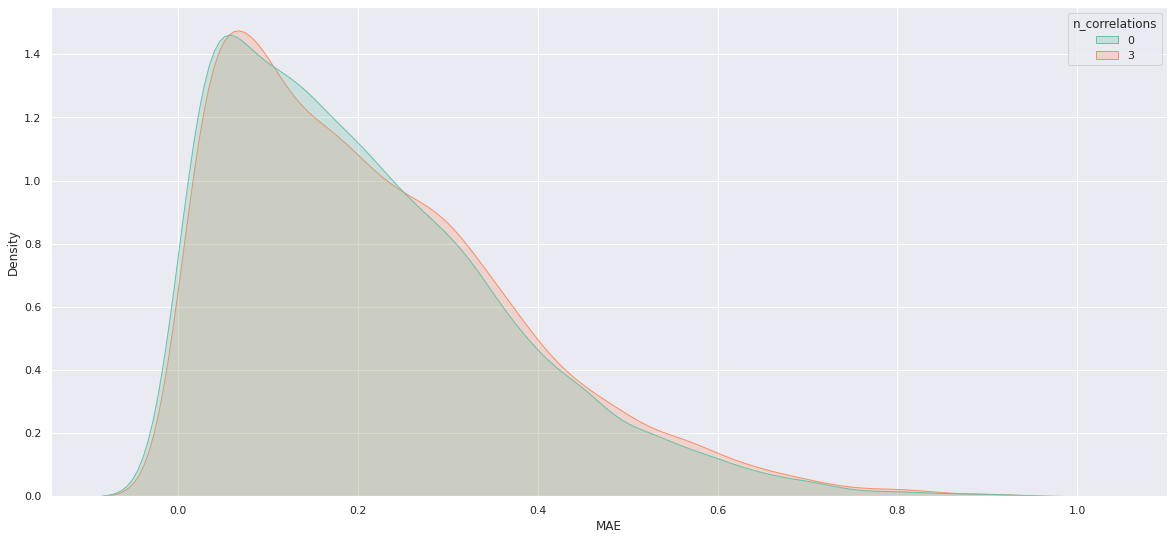

In [283]:
sns.kdeplot(
    data=fulldf[fulldf['method'] == 'IntegratedGradients'], x="MAE", hue="n_correlations",
    fill=True, common_norm=True, palette="Set2",
    alpha=.25,
)

In [262]:
from scipy.stats import kstest

In [296]:
for method in methods:
    df1 = fulldf[fulldf['n_correlations'] == 0]
    df3 = fulldf[fulldf['n_correlations'] == 3]
    mae1 = df1[df1['method'] == method]['MAE'].to_numpy()
    mae3 = df3[df3['method'] == method]['MAE'].to_numpy()
    print(f'{method} {kstest(mae1, mae3, alternative="greater")}')

FeaturePermutation KstestResult(statistic=0.074, pvalue=1.2569934849318119e-12)
IntegratedGradients KstestResult(statistic=0.0288, pvalue=0.015806111106984783)
InputxGradient KstestResult(statistic=0.0364, pvalue=0.0013259834965467902)
Lime KstestResult(statistic=0.0618, pvalue=5.036970862110796e-09)
KernelExplainer KstestResult(statistic=0.0282, pvalue=0.01875435247317721)
DeepExplainer KstestResult(statistic=0.0286, pvalue=0.016740093789238155)


In [ ]:
FeaturePermutation KstestResult(statistic=0.074, pvalue=1.2569934849318119e-12)
IntegratedGradients KstestResult(statistic=0.0288, pvalue=0.015806111106984783)
InputxGradient KstestResult(statistic=0.0364, pvalue=0.0013259834965467902)
Lime KstestResult(statistic=0.0618, pvalue=5.036970862110796e-09)
KernelExplainer KstestResult(statistic=0.0282, pvalue=0.01875435247317721)
DeepExplainer KstestResult(statistic=0.0286, pvalue=0.016740093789238155)

In [271]:
kstest(mae1, mae3)

KstestResult(statistic=0.074, pvalue=2.513986969863627e-12)

In [ ]:
boxplot

In [33]:
concat_dataframe('linear_revised_1', n_features=4)

 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_1/ConcatMeanError_feature0.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_1/ConcatMeanError_feature1.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_1/ConcatMeanError_feature2.csv
 wrote /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_1/ConcatMeanError_feature3.csv


In [5]:
import pandas as pd
from scipy.stats import kstest

In [7]:
methods = ['FeaturePermutation',
           'IntegratedGradients',
           'InputxGradient',
           'Lime',
           'KernelExplainer',
           'DeepExplainer']

In [6]:
experiment_id = 'linear_revised_3'
ds3 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature0.csv')
ds3.loc[:, 'feature'] = 'feature0'
ds2 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature1.csv')
ds2.loc[:, 'feature'] = 'feature1'
ds1 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature2.csv')
ds1.loc[:, 'feature'] = 'feature2'
independent_ds = pd.concat([ds1, ds2, ds3], ignore_index=True)
independent_ds.loc[:, 'feature_set'] = 'independent'

ds3 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature3.csv')
ds3.loc[:, 'feature'] = 'feature3'
ds2 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature4.csv')
ds2.loc[:, 'feature'] = 'feature4'
ds1 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}/ConcatMeanError_feature5.csv')
ds1.loc[:, 'feature'] = 'feature5'
dependent_ds = pd.concat([ds1, ds2, ds3], ignore_index=True)
dependent_ds.loc[:, 'feature_set'] = 'dependent'

complete_ds = pd.concat([dependent_ds, independent_ds], ignore_index=True)
del complete_ds['median_absolute_error']
del complete_ds['unclipped_absolute_error']
del complete_ds['absolute_error']

In [9]:
for method in methods:
    df1 = complete_ds[complete_ds['feature_set'] == 'independent']
    df3 = complete_ds[complete_ds['feature_set'] == 'dependent']
    mae1 = df1[df1['method'] == method]['MAE'].to_numpy()
    mae3 = df3[df3['method'] == method]['MAE'].to_numpy()
    print(f'{method} {kstest(mae1, mae3, alternative="greater")}')

FeaturePermutation KstestResult(statistic=0.2893315673289183, pvalue=0.0)
IntegratedGradients KstestResult(statistic=0.16421059602649013, pvalue=4.820888594436918e-177)
InputxGradient KstestResult(statistic=0.16598322295805734, pvalue=7.190083874884908e-181)
Lime KstestResult(statistic=0.16232671081677708, pvalue=5.065928763324633e-173)
KernelExplainer KstestResult(statistic=0.16406710816777048, pvalue=9.796321293635988e-177)
DeepExplainer KstestResult(statistic=0.1642114790286976, pvalue=4.799889859829545e-177)


In [4]:
complete_ds

,Unnamed: 0,feature0_orig,feature1_orig,feature2_orig,feature3_orig,feature4_orig,feature5_orig,unclipped_MAE,MAE,median_MAE,method,feature,feature_set
0,25100,-4.409981,6.583811,15.950713,8.983177,5.855163,7.527378,0.027768,0.035266,0.117208,FeaturePermutation,feature5,dependent
1,25101,-0.614181,0.685218,22.615474,-0.481572,-0.144852,15.250847,0.042050,0.036445,0.088245,FeaturePermutation,feature5,dependent
2,25102,0.907999,8.471696,22.336496,8.717135,1.357045,7.301335,0.029997,0.034904,0.104874,FeaturePermutation,feature5,dependent
3,25103,7.255474,4.280624,19.575098,8.614008,10.585169,13.607165,0.031864,0.034163,0.086754,FeaturePermutation,feature5,dependent
4,25104,-1.139844,1.667867,26.298472,16.561717,23.600216,16.528759,0.055782,0.055172,0.080911,FeaturePermutation,feature5,dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180595,5095,0.080076,3.913446,82.950071,17.883694,18.939499,9.049063,0.021731,0.053797,0.086823,DeepExplainer,feature0,independent
180596,5096,-10.773462,2.764457,16.151260,10.840175,11.191761,19.276817,0.232915,0.258843,0.294446,DeepExplainer,feature0,independent
180597,5097,9.321502,2.887395,27.635340,6.742770,4.984124,15.370397,0.157882,0.132864,0.096645,DeepExplainer,feature0,independent
180598,5098,0.792005,2.854833,3.280840,28.368668,20.042707,40.643834,0.007535,0.036476,0.063832,DeepExplainer,feature0,independent


In [244]:
EVALUATION_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation'

In [227]:
ds

,Unnamed: 0,feature0_orig,feature1_orig,feature2_orig,feature3_orig,feature4_orig,feature5_orig,unclipped_MAE,MAE,median_MAE,method,feature_set,feature
25000,15100,-1.600297,1.160718,22.934888,-0.532154,1.731216,4.339722,0.275222,0.346068,0.411179,DeepExplainer,dependent,NaN
25001,15101,7.267520,12.236927,82.639847,19.382078,11.431457,18.005017,0.249015,0.176201,0.115770,DeepExplainer,dependent,NaN
25002,15102,-6.902593,9.960215,40.172565,21.595461,20.844924,29.875542,0.308250,0.234294,0.164289,DeepExplainer,dependent,NaN
25003,15103,-5.163549,8.783069,14.445232,31.699918,32.447723,37.079771,0.590774,0.492106,0.449756,DeepExplainer,dependent,NaN
25004,15104,0.889039,2.660884,25.257101,-6.974627,-10.952289,-3.981330,0.440140,0.513017,0.578576,DeepExplainer,dependent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120595,5095,0.080076,3.913446,82.950071,17.883694,18.939499,9.049063,0.021731,0.053797,0.086823,DeepExplainer,independent,feature0
120596,5096,-10.773462,2.764457,16.151260,10.840175,11.191761,19.276817,0.232915,0.258843,0.294446,DeepExplainer,independent,feature0
120597,5097,9.321502,2.887395,27.635340,6.742770,4.984124,15.370397,0.157882,0.132864,0.096645,DeepExplainer,independent,feature0
120598,5098,0.792005,2.854833,3.280840,28.368668,20.042707,40.643834,0.007535,0.036476,0.063832,DeepExplainer,independent,feature0


In [240]:
completeds = pd.read_csv(f'{EVALUATION_DIR}/dependence_group_ds1.csv')

In [242]:
completeds

,Unnamed: 0,Unnamed: 0.1,feature0_orig,feature1_orig,feature2_orig,feature3_orig,feature4_orig,absolute_error,unclipped_absolute_error,median_absolute_error,unclipped_MAE,MAE,median_MAE,method,feature,feature_set
0,0,10100,2.991878,0.336159,5.869631,7.064188,8.404492,"[0.04201002023231896, 0.04493019656715976, 0.0...","[0.007050912658855208, 0.04155747245661367, 8....","[0.1879240374720591, 0.10817291287919034, 0.07...",0.007412,0.025415,0.108653,FeaturePermutation,feature2,dependent
1,1,10101,-8.042339,7.736151,2.921270,-9.194160,-9.903655,"[0.1899647712458768, 0.05133609572216575, 0.06...","[0.004131325299339251, 0.0019874227407074485, ...","[0.560368340504437, 0.1142807957023998, 0.1789...",0.005234,0.106849,0.272087,FeaturePermutation,feature2,dependent
2,2,10102,2.185384,1.288675,19.426832,23.904327,22.207773,"[0.057289314110067456, 0.01708189556121409, 0....","[0.04184222273326899, 0.003789839319997503, 0....","[0.282795796142154, 0.14474118726489624, 0.145...",0.005733,0.026399,0.097444,FeaturePermutation,feature2,dependent
3,3,10103,1.587252,2.442608,46.379307,4.586729,6.288897,"[0.03963594845001977, 0.02307176680943902, 0.0...","[0.002174171089271212, 0.013344067344475023, 0...","[0.20871399557841053, 0.06943199145260118, 0.1...",0.014368,0.021282,0.110294,FeaturePermutation,feature2,dependent
4,4,10104,-12.021602,2.327831,18.209605,6.465982,9.362388,"[0.03451285738036701, 0.004658286394666093, 0....","[0.0302821673638716, 9.252080074344925e-05, 0....","[0.16958040628097126, 0.07789800236205777, 0.1...",0.007229,0.021877,0.105644,FeaturePermutation,feature2,dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180595,180595,5095,0.080076,3.913446,82.950071,17.883694,18.939499,"[0.017532505870119425, 0.05706466203697007, 0....","[0.017236744953964454, 0.019399242740149997, 0...","[0.09116767648291403, 0.09521267957670551, 0.1...",0.019339,0.058902,0.105376,DeepExplainer,feature0,independent
180596,180596,5096,-10.773462,2.764457,16.151260,10.840175,11.191761,"[0.22843907066634417, 0.22866061323709824, 0.2...","[0.20402302710799278, 0.2027569118662372, 0.22...","[0.2679007233201032, 0.2670674834705593, 0.322...",0.204893,0.236887,0.279816,DeepExplainer,feature0,independent
180597,180597,5097,9.321502,2.887395,27.635340,6.742770,4.984124,"[0.10208063543375537, 0.10944745951630613, 0.1...","[0.14087218860012943, 0.1399780432134488, 0.15...","[0.05104371439148124, 0.07098034959037391, 0.0...",0.141086,0.109504,0.065352,DeepExplainer,feature0,independent
180598,180598,5098,0.792005,2.854833,3.280840,28.368668,20.042707,"[0.0779111718981639, 0.04700854854983683, 0.00...","[0.007869805601303757, 0.007136663724219807, 0...","[0.22591961325195076, 0.08465627742540617, 0.0...",0.006754,0.039813,0.093804,DeepExplainer,feature0,independent


<AxesSubplot:xlabel='MAE', ylabel='Density'>

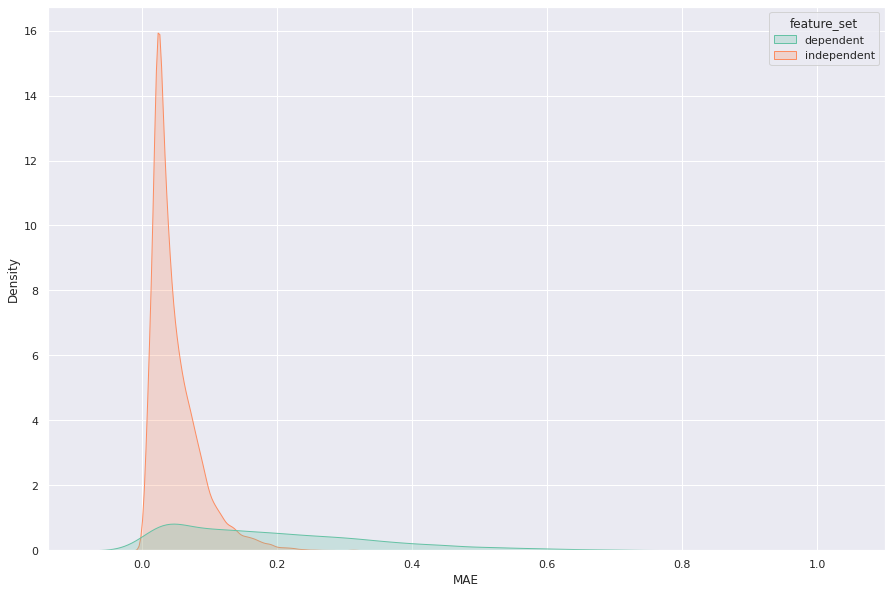

In [241]:
sns.kdeplot(
    data=complete_ds[complete_ds['method'] == 'Lime'], x="MAE", hue="feature_set",
    fill=True, common_norm=True, palette="Set2",
    alpha=.25,
)

<AxesSubplot:xlabel='unclipped_MAE', ylabel='Density'>

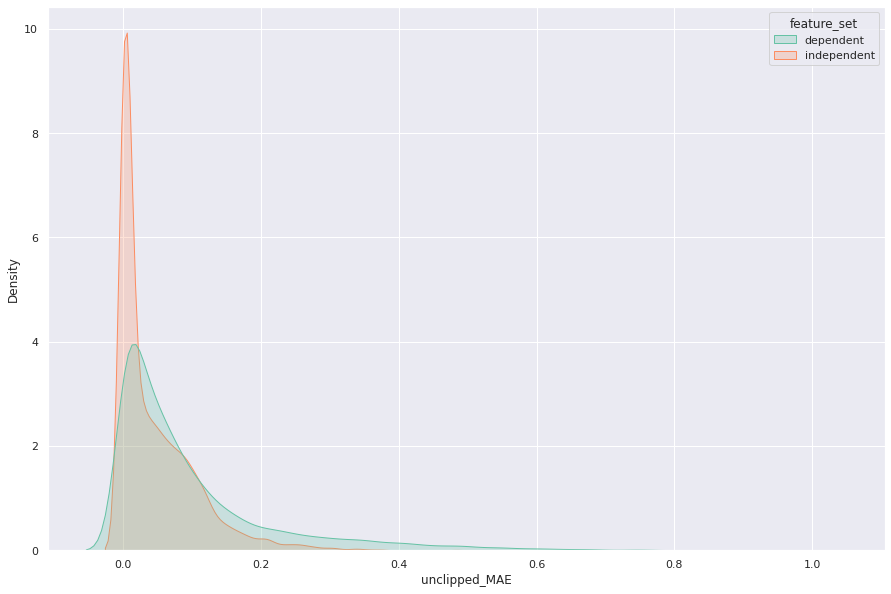

In [188]:
sns.kdeplot(
    data=complete_ds[complete_ds['method'] == 'Lime'], x="unclipped_MAE", hue="feature_set",
    fill=True, common_norm=True, palette="Set2",
    alpha=.25,
)

In [88]:
concat_ds = pd.concat([ds1, ds2, ds3], ignore_index=True)

In [89]:
import seaborn as sns

In [91]:
concat_ds = pd.concat([ds1, ds2, ds3], ignore_index=True)
# concat_ds.loc[:, 'Delta_LPG'] = concat_ds['MAE'] * 10
# concat_ds = concat_ds[concat_ds['method']== 'FeaturePermutation']

In [95]:
concat_ds

,Unnamed: 0,feature0_orig,feature1_orig,feature2_orig,feature3_orig,absolute_error,unclipped_absolute_error,median_absolute_error,unclipped_MAE,MAE,median_MAE,method,n_correlations,feature4_orig,feature5_orig
0,15100,-1.600297,1.160718,22.934888,-0.532154,"[0.09172596234327546, 0.015702030811906464, 0....","[0.05543480041362537, 0.023448144450486142, 0....","[0.3132644764224376, 0.2567213685464225, 0.568...",0.252804,0.282790,0.488999,FeaturePermutation,0,NaN,NaN
1,15101,7.267520,12.236927,82.639847,19.382078,"[0.24175094703171573, 0.2509529520522138, 0.05...","[0.20077318926450397, 0.28044570008486946, 0.0...","[0.35654783735498286, 0.13696595597870156, 0.2...",0.213774,0.202387,0.195956,FeaturePermutation,0,NaN,NaN
2,15102,-6.902593,9.960215,40.172565,21.595461,"[0.3413381406980677, 0.1819063714061115, 0.294...","[0.3727704347603857, 0.1461731848186255, 0.330...","[0.14216014955604872, 0.4133267121027949, 0.07...",0.253961,0.232958,0.147966,FeaturePermutation,0,NaN,NaN
3,15103,-5.163549,8.783069,14.445232,31.699918,"[0.24988550581313373, 0.5204892718725371, 0.37...","[0.27589973338383716, 0.5437309260712745, 0.40...","[0.007114949377983015, 0.254557733892465, 0.14...",0.368755,0.335087,0.156861,FeaturePermutation,0,NaN,NaN
4,15104,0.889039,2.660884,25.257101,-6.974627,"[0.3734778635719324, 0.49000195440826105, 0.23...","[0.34041663276577816, 0.4623623128659904, 0.19...","[0.6648116291537998, 0.7327090803091454, 0.341...",0.266022,0.297167,0.517853,FeaturePermutation,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,20095,-1.246440,2.747808,59.378151,1.937009,"[0.2563490066186619, 0.26680867337919195, 0.29...","[0.190964536276522, 0.20676759863794028, 0.220...","[0.3159144505346515, 0.320303809033476, 0.3525...",0.212001,0.284960,0.349854,DeepExplainer,3,13.070785,5.141171
89996,20096,-2.557968,2.482532,9.491518,12.734129,"[0.005394691377399147, 0.03433623886188102, 0....","[0.06682360714717052, 0.07157920890573677, 0.0...","[0.07631551942652234, 0.05690581843008677, 0.0...",0.072403,0.025842,0.065748,DeepExplainer,3,19.411108,23.868067
89997,20097,4.844323,5.670923,28.627106,-3.611590,"[0.3499981052663807, 0.390514994823254, 0.5436...","[0.31095845996980803, 0.3426574743964197, 0.37...","[0.44464539391128477, 0.5164017060273502, 0.57...",0.353760,0.437969,0.500070,DeepExplainer,3,-1.108961,1.419429
89998,20098,8.290194,2.851677,35.575136,-0.618108,"[0.3051234282706266, 0.14939594117586485, 0.37...","[0.24597460793250486, 0.26676782196760457, 0.2...","[0.40681703458703705, 0.3353817413457488, 0.48...",0.277509,0.364477,0.428609,DeepExplainer,3,-8.518399,-5.826748


In [101]:
methods = ['FeaturePermutation',
           'IntegratedGradients',
           'InputxGradient',
           'Lime',
           'KernelExplainer',
           'DeepExplainer']

for method in methods:
    attrds = concat_ds[concat_ds['method'] == method]
    nc0 = attrds[attrds['n_correlations'] == 0]['MAE'].values.mean()
    nc3 = attrds[attrds['n_correlations'] == 3]['MAE'].values.mean()
    print(f'{method} -- {nc3 - nc0}')

FeaturePermutation -- 0.011996317080514157
IntegratedGradients -- 0.00895588810036374
InputxGradient -- 0.012071652748821132
Lime -- 0.0066807913530320395
KernelExplainer -- 0.008923427191759509
DeepExplainer -- 0.008925487883709643


In [102]:
concat_ds['MAE']

0        0.282790
1        0.202387
2        0.232958
3        0.335087
4        0.297167
           ...   
89995    0.284960
89996    0.025842
89997    0.437969
89998    0.364477
89999    0.183874
Name: MAE, Length: 90000, dtype: float64

In [85]:
concat_ds

NameError: name 'concat_ds' is not defined

Text(0.5, 1.05, 'Delta to LPG With Increasing Number of Correlations')

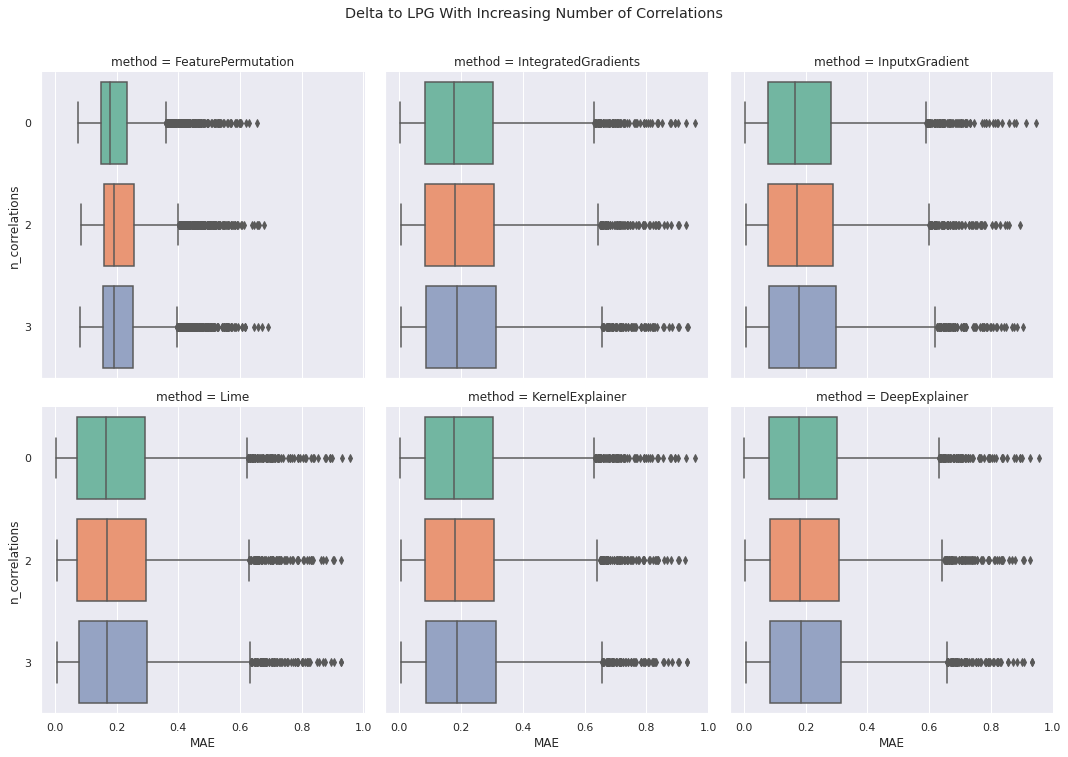

In [126]:
sns.set(rc={'figure.figsize':(20, 9)})
ax = sns.catplot(
    data=concat_ds, x='MAE', y='n_correlations', orient='h',
    col='method', kind='box', col_wrap=3, palette='Set2', margin_titles=True,
)
ax.fig.suptitle('Delta to LPG With Increasing Number of Correlations', y=1.05)

In [ ]:
ax.set_title('lalala')
ax.set_ylabel('lololo')

In [ ]:
idx = 1
experiment_id = 'simpsons_cc'
ixg = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_InputxGradient.csv', index_col=0)
ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_KernelExplainer.csv', index_col=0)

In [ ]:
array = ixg['MAE'].to_numpy()
outliers = np.percentile(array, [1, 90])
clipped_array = np.clip(array, *outliers)

In [153]:
def flatten_errors(experiment_id, idx):
    """
    :param experiment_id: experiment identifier
    :return:
    """
    dfs = []
    methods = ['FeaturePermutation',
               'IntegratedGradients',
               'InputxGradient',
               'Lime',
               'KernelExplainer',
               'DeepExplainer']
    for method in methods:
        data = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
        absolute_error = col2numpy(data, 'absolute_error').flatten().tolist()
        median_absolute_error = col2numpy(data, 'median_absolute_error').flatten().tolist()
        unclipped_absolute_error = col2numpy(data, 'unclipped_absolute_error').flatten().tolist()
        df = pd.DataFrame(dict(abs_error = absolute_error, median_abs_error=median_absolute_error, unclipped_absolute_error=unclipped_absolute_error))
        df.loc[:, 'attribution_method'] = method
        dfs.append(df)

    df = dfs[0]
    dfs.pop(0)
    full_df = df.append(dfs, ignore_index=True)
    full_df.to_csv(f'{EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}.csv')
    print(f'WROTE -- {EVALUATION_DIR}/{experiment_id}/FlattenedError_feature{idx}.csv')
    return full_df

In [ ]:
import plotly.graph_objects as go
from plotly.colors import n_colors

In [142]:
idx = 3
method = 'FeaturePermutation'
experiment_id = 'linear_revised_1'
data = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)

In [155]:
flatten_errors('linear_revised_3', idx=3)

WROTE -- /data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/linear_revised_3/FlattenedError_feature3.csv


,abs_error,median_abs_error,unclipped_absolute_error,attribution_method
0,0.267375,0.334448,0.190247,FeaturePermutation
1,0.191042,0.259874,0.121509,FeaturePermutation
2,0.232356,0.295031,0.171139,FeaturePermutation
3,0.648358,0.729663,0.539084,FeaturePermutation
4,0.366955,0.434510,0.291935,FeaturePermutation
...,...,...,...,...
629995,0.189609,0.258970,0.108769,DeepExplainer
629996,0.185770,0.245603,0.116971,DeepExplainer
629997,0.168224,0.244756,0.101119,DeepExplainer
629998,0.189404,0.266034,0.119291,DeepExplainer


In [143]:
data

,feature0_orig,feature1_orig,feature2_orig,feature3_orig,absolute_error,unclipped_absolute_error,median_absolute_error,unclipped_MAE,MAE,median_MAE,method
15100,-1.600297,1.160718,22.934888,-0.532154,"[0.09172596234327546, 0.015702030811906464, 0....","[0.05543480041362537, 0.023448144450486142, 0....","[0.3132644764224376, 0.2567213685464225, 0.568...",0.252804,0.282790,0.488999,FeaturePermutation
15101,7.267520,12.236927,82.639847,19.382078,"[0.24175094703171573, 0.2509529520522138, 0.05...","[0.20077318926450397, 0.28044570008486946, 0.0...","[0.35654783735498286, 0.13696595597870156, 0.2...",0.213774,0.202387,0.195956,FeaturePermutation
15102,-6.902593,9.960215,40.172565,21.595461,"[0.3413381406980677, 0.1819063714061115, 0.294...","[0.3727704347603857, 0.1461731848186255, 0.330...","[0.14216014955604872, 0.4133267121027949, 0.07...",0.253961,0.232958,0.147966,FeaturePermutation
15103,-5.163549,8.783069,14.445232,31.699918,"[0.24988550581313373, 0.5204892718725371, 0.37...","[0.27589973338383716, 0.5437309260712745, 0.40...","[0.007114949377983015, 0.254557733892465, 0.14...",0.368755,0.335087,0.156861,FeaturePermutation
15104,0.889039,2.660884,25.257101,-6.974627,"[0.3734778635719324, 0.49000195440826105, 0.23...","[0.34041663276577816, 0.4623623128659904, 0.19...","[0.6648116291537998, 0.7327090803091454, 0.341...",0.266022,0.297167,0.517853,FeaturePermutation
...,...,...,...,...,...,...,...,...,...,...,...
20095,-1.246440,2.747808,59.378151,1.937009,"[0.3816302268849195, 0.12484329260752194, 0.27...","[0.347821071028703, 0.15968210172920624, 0.252...","[0.5936720343492754, 0.09369770253790627, 0.44...",0.194212,0.214536,0.394352,FeaturePermutation
20096,-2.557968,2.482532,9.491518,12.734129,"[0.016647475157337784, 0.1683934316980854, 0.2...","[0.044846987495450366, 0.20203802725191394, 0....","[0.19074768086578614, 0.05839299174458304, 0.4...",0.143707,0.139510,0.238826,FeaturePermutation
20097,4.844323,5.670923,28.627106,-3.611590,"[0.3315153653692572, 0.26877818566933215, 0.33...","[0.3215357091637021, 0.2347843045986201, 0.284...","[0.4875607439527555, 0.4982680910762668, 0.575...",0.254780,0.291069,0.512728,FeaturePermutation
20098,8.290194,2.851677,35.575136,-0.618108,"[0.18231525659295267, 0.5318724477826998, 0.00...","[0.15204091097815037, 0.5077823503464404, 0.04...","[0.34090004854788813, 0.7306600066120509, 0.19...",0.268381,0.293661,0.496824,FeaturePermutation


In [ ]:
flattened_df = flatten_errors('linear_cc_3', idx=5)

In [ ]:
flattened_df[flattened_df['attribution_method'=='FeaturePermutation']]

In [ ]:
import scipy

In [ ]:
shape, loc, scale = scipy.stats.gamma.fit(fp)

In [ ]:
plt.hist(fp)

In [ ]:
bins = np.linspace(0, 1.0, 100)

In [ ]:
gamma_estimate = scipy.stats.gamma.rvs(shape, loc, scale, size=190000)
plt.hist(fp, bins, alpha=0.5, label='actual errors')
plt.hist(gamma_estimate, bins,  alpha=0.5, label='estimated gamma distribution')
plt.legend(loc='upper right')
plt.show()

In [ ]:
scipy.stats.gamma.interval(0.95, shape, loc, scale)

In [ ]:
fp = flattened_df.loc[flattened_df['attribution_method'] =='FeaturePermutation']['abs_error'].to_numpy().reshape(-1, 1)

In [ ]:
sns.set(rc={'figure.figsize':(12, 12)})
ax = sns.violinplot(data=flattened_df, y='attribution_method', x='abs_error', scale='count', palette='turbo', bw=1.0,
                    inner=None, linewidth=0, saturation=0.4, orient='h', legend=True)
g = sns.boxplot(data=flattened_df, y='attribution_method', x='abs_error', palette='turbo', width=0.1, showfliers=True,
                boxprops={'zorder': 2}, orient='h', ax=ax)

In [ ]:
sns.set(rc={'figure.figsize':(12, 12)})
ax = sns.violinplot(data=concat_df, y='method', x='MAE', scale='count', palette='turbo',
               inner=None, linewidth=0, saturation=0.4, orient='h', legend=True)
g = sns.boxplot(data=concat_df, y='method', x='MAE', palette='turbo', width=0.1, showfliers=True,
                  boxprops={'zorder': 2}, orient='h', ax=ax)

In [ ]:
concat_df

In [ ]:
data = np.concatenate((concat_df[concat_df['method']=='FeaturePermutation']['MAE'].to_numpy().reshape(-1, 1),
                concat_df[concat_df['method']=='IntegratedGradients']['MAE'].to_numpy().reshape(-1, 1),
                concat_df[concat_df['method']=='InputxGradient']['MAE'].to_numpy().reshape(-1, 1),
                concat_df[concat_df['method']=='Lime']['MAE'].to_numpy().reshape(-1, 1),
                concat_df[concat_df['method']=='KernelExplainer']['MAE'].to_numpy().reshape(-1, 1),
                concat_df[concat_df['method']=='DeepExplainer']['MAE'].to_numpy().reshape(-1, 1)), axis=1)

In [ ]:
data.shape

In [ ]:
import plotly.graph_objects as go
from plotly.colors import n_colors
import numpy as np
np.random.seed(1)

# 12 sets of normal distributed random data, with increasing mean and standard deviation

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', 6, colortype='rgb')

fig = go.Figure()
for data_line, color in zip(data, colors):
    fig.add_trace(go.Violin(x=data_line, line_color=color))

fig.update_traces(orientation='h', side='positive', width=2, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [ ]:
methods = ['FeaturePermutation',
           'IntegratedGradients',
           'InputxGradient',
           'Lime',
           'KernelExplainer',
           'DeepExplainer']
fig = go.Figure()
for method in methods:
    fig.add_trace(go.Violin(y=concat_df['method'][concat_df['method'] == method],
                            x=concat_df['MAE'][concat_df['method'] == method],
                            orientation='h',
                            name=method,
                            box_visible=True,
                            meanline_visible=True))

fig.show()

In [ ]:
df = flatten_errors('lr_simpsons', idx=0)
sns.set(rc={'figure.figsize':(10,10)})
sns.kdeplot(
    data=full_df, x="median_abs_error", hue="attribution_method",
    fill=True, common_norm=True, palette="Spectral_r",
    alpha=.25,
)

## Inspect distributions

In [ ]:
df

In [ ]:
df.plot.scatter('feature0_orig', 'feature1_orig', c='median_MAE', cmap='seismic')

In [ ]:
g = sns.boxplot(x="median_MAE", y="attribution_method", data=df, orient='h')

In [ ]:
df = compare_methods('lr_simpsons', dimension='both')

In [ ]:
compare_methods('lr_simpsons', dimension=0, metric='median_MAE')

In [ ]:
fulldf = compare_multidim('lr_simpsons', dimension='both', metric='median_MAE', n_features=2)

In [ ]:
df

In [ ]:
df

In [ ]:
sns.set(rc={'figure.figsize': (8,8)})
idx = 0
method = 'KernelExplainer'
experiment_id = ''
df = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
error = df['median_MAE'].to_numpy()
upper = np.percentile(error, [95.0])
posterror = np.where(error>=upper, 1, -1)
df.loc[:, 'posterror'] = posterror
df.plot.scatter('feature0_orig', 'feature1_orig', c='posterror', cmap='seismic')

In [ ]:
n_features=4
full_df = compare_multidim('linear_decreasing_1', dimension=0, metric='median_abs_error', n_features=n_features)
full_df.loc[:, 'n_features'] = n_features

In [ ]:
def extract_df(experiment_id, n_features, idx=3):
    full_df = compare_multidim(experiment_id, dimension=0, metric='median_abs_error', n_features=n_features)
    full_df = full_df[full_df['idx']==idx]
    full_df = full_df[full_df['attribution_method']=='DeepExplainer']
    full_df.loc[:, 'experiment_id'] = experiment_id
    return full_df

In [ ]:
idx = 0
df1 = extract_df('linear_decreasing_1', 4, idx)
df2 = extract_df('linear_decreasing_2', 5, idx)
df3 = extract_df('linear_decreasing_3', 6, idx)
fulldf = df1.append([df2, df3], ignore_index=True)

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.kdeplot(
    data=fulldf, x="MAE", hue='experiment_id',
    fill=True, palette="Set2",
    alpha=.25,
)

In [ ]:
fulldf

In [ ]:
df1

In [ ]:
sns.kdeplot

In [ ]:
full_df

In [ ]:
metric = 'MAE'
sns.set(rc={'figure.figsize': (10,10)})
ax = sns.violinplot(data=full_df,
                    y='attribution_method',
                    x=metric,
                    hue='idx',
                    scale='count',
                    inner=None,
                    palette='turbo',
                    orient='h')

In [ ]:
def compare_multidim(experiment_id:str, dimension:0, metric:'median_abs_error', n_features:5) -> pd.DataFrame:
    method = 'FeatureAblation'
    fa_dfs = []
    for idx in range(n_features):
        for experiment_id in experiment_ids:
            fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
            fa.loc[:, 'idx'] = idx
            fa.loc[:, 'attribution_method'] = method
            fa_dfs.append(fa)

    method = 'FeaturePermutation'
    fp_dfs = []
    for idx in range(n_features):
        fp = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
        fp.loc[:, 'idx'] = idx
        fp.loc[:, 'attribution_method'] = method
        fp_dfs.append(fp)

    method = 'KernelExplainer'
    ke_dfs = []
    for idx in range(n_features):
        ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
        ke.loc[:, 'idx'] = idx
        ke.loc[:, 'attribution_method'] = method
        ke_dfs.append(ke)

    method = 'DeepExplainer'
    de_dfs = []
    for idx in range(n_features):
        de = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
        de.loc[:, 'idx'] = idx
        de.loc[:, 'attribution_method'] = method
        de_dfs.append(de)

    method = 'IntegratedGradients'
    ig_dfs = []
    for idx in range(n_features):
        ig = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
        ig.loc[:, 'idx'] = idx
        ig.loc[:, 'attribution_method'] = method
        ig_dfs.append(ig)

    method = 'Lime'
    lime_dfs = []
    for idx in range(n_features):
        lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
        lime.loc[:, 'idx'] = idx
        lime.loc[:, 'attribution_method'] = method
        lime_dfs.append(lime)

    dfs = lime_dfs + fa_dfs + fp_dfs + ke_dfs + de_dfs + ig_dfs
    full_df = pd.concat(dfs)
    return full_df

    # if dimension==0 or dimension==1:
    #     sns.set(rc={'figure.figsize': (10,10)})
    #     ax = sns.violinplot(data=full_df, x='attribution_method', y=metric, palette='turbo',
    #                         inner=None, linewidth=0, saturation=0.4, orient='v', scale='count', bins=2000)
    #     sns.boxplot(data=full_df, y='attribution_method', x=metric, palette='turbo', width=0.08,
    #                 boxprops={'zorder': 2}, orient='h', ax=ax)
    # else:
    #     sns.set(rc={'figure.figsize': (10,10)})
    #     ax = sns.violinplot(data=full_df,
    #                         x='attribution_method',
    #                         y=metric,
    #                         hue='idx',
    #                         scale='count',
    #                         split=True,
    #                         inner=None,
    #                         palette='turbo',
    #                         orient='h')
    #     g = sns.boxplot(data=full_df, y='attribution_method', x=metric, palette='turbo', width=0.08,
    #                     boxprops={'zorder': 2}, orient='h', ax=ax)
    # plt.suptitle(experiment_id)
    # return full_df

In [ ]:
def compare_methods_singledim(experiment_id:str, dimension:0, metric:'median_abs_error', n_features:5) -> pd.DataFrame:
    method = 'FeatureAblation'
    xdf_fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    fa_dfs = []
    for idx in range(n_features):
        fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature{idx}_{method}.csv', index_col=0)
    for df in [xdf_fa, ydf_fa]:
        df.loc[:, 'attribution_method'] = method

    method = 'FeaturePermutation'
    xdf_fp = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_fp = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_fp, ydf_fp]:
        df.loc[:, 'attribution_method'] = method

    method = 'KernelExplainer'
    xdf_ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_ke, ydf_ke]:
        df.loc[:, 'attribution_method'] = method

    method = 'DeepExplainer'
    xdf_de = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_de = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_de, ydf_de]:
        df.loc[:, 'attribution_method'] = method

    method = 'IntegratedGradients'
    xdf_ig = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_ig = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_ig, ydf_ig]:
        df.loc[:, 'attribution_method'] = method

    method = 'Lime'
    xdf_lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_lime, ydf_lime]:
        df.loc[:, 'attribution_method'] = method

    full_xdf = xdf_de.append([xdf_lime, xdf_ig, xdf_fa, xdf_ke, xdf_fp], ignore_index=True)
    full_xdf.loc[:, 'modified_attribute'] = 'noise0'
    full_ydf = ydf_de.append([ydf_lime, ydf_ig, ydf_fa, ydf_ke, ydf_fp], ignore_index=True)
    full_ydf.loc[:, 'modified_attribute'] = 'noise1'

    full_df = full_xdf if dimension==0 else full_ydf if dimension==1 else full_xdf.append(full_ydf, ignore_index=True)
    full_df.loc[:, 'squared_error'] = np.log10(full_df['median_MAE'].to_numpy())
    full_df.loc[:, 'log10_median_error'] = np.log10(full_df['median_MAE'].to_numpy())
    full_df.loc[:, 'log2_median_error'] = np.log2(full_df['median_MAE'].to_numpy())

    if dimension==0 or dimension==1:
        sns.set(rc={'figure.figsize': (10,10)})
        ax = sns.violinplot(data=full_df, x='attribution_method', y=metric, palette='turbo',
                            inner=None, linewidth=0, saturation=0.4, orient='v', scale='count', bins=2000)
        sns.boxplot(data=full_df, y='attribution_method', x=metric, palette='turbo', width=0.08,
                        boxprops={'zorder': 2}, orient='h', ax=ax)
    else:
        sns.set(rc={'figure.figsize': (10,10)})
        ax = sns.violinplot(data=full_df,
                       x='attribution_method',
                       y=metric,
                       hue='modified_attribute',
                       scale='count',
                       split=True,
                       inner=None,
                       palette='turbo',
                       orient='h')
        g = sns.boxplot(data=full_df, y='attribution_method', x=metric, palette='turbo', width=0.08,
                        boxprops={'zorder': 2}, orient='h', ax=ax)
    plt.suptitle(experiment_id)
    return full_df


def plot_distributions(method):
    experiment_id = 'p0.75'
    xdf_75 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_75 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_75, ydf_75]:
        df.loc[:, 'correlation_coefficient'] = 0.75

    experiment_id = 'p0.5'
    xdf_50 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_50 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_50, ydf_50]:
        df.loc[:, 'correlation_coefficient'] = 0.50

    experiment_id = 'p0.25'
    xdf_25 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_25 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_25, ydf_25]:
        df.loc[:, 'correlation_coefficient'] = 0.25

    experiment_id = 'p0.00'
    xdf_00 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_00 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_00, ydf_00]:
        df.loc[:, 'correlation_coefficient'] = 0.00

    full_xdf = xdf_75.append([xdf_00, xdf_25, xdf_50], ignore_index=True)
    full_xdf.loc[:, 'modified_attribute'] = 'noise_x'
    full_ydf = ydf_75.append([xdf_00, ydf_25, ydf_50], ignore_index=True)
    full_ydf.loc[:, 'modified_attribute'] = 'noise_y'
    full_df = full_xdf.append(full_ydf, ignore_index=True)
    sns.set(rc={'figure.figsize':(20,10)})
    sns.displot(data=full_df,
                x='MAE',
                hue="correlation_coefficient",
                col='modified_attribute',
                fill=True,
                kind='kde',
                palette='crest',
                alpha=0.1,
                linewidth=2.0,
                legend=True)
    plt.ylim(0.00, 1.2)
    plt.suptitle(method, y=0.99, x=0.45)

In [7]:
import wandb
from lifelines import CoxPHFitter

In [8]:
train_ds = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/linear_revised_1_train.csv')
def fit_coxph(df):
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    concordance = cph.concordance_index_
    print(f'concordance = {cph.concordance_index_}')
    return concordance, cph

In [206]:
concordance, cph = fit_coxph(train_ds)

concordance = 0.7823041424280615


In [125]:
ctds

[0.7758519053459167,
 0.7760446667671204,
 0.7757485508918762,
 0.7760459780693054,
 0.7764022350311279,
 0.7763851881027222,
 0.775996208190918,
 0.7758861184120178,
 0.7764049172401428,
 0.7763457894325256,
 0.7763424515724182,
 0.7759252786636353,
 0.7765106558799744,
 0.7766516208648682,
 0.7753127813339233,
 0.7756422162055969,
 0.7764720916748047,
 0.7756316661834717,
 0.7761095762252808,
 0.7759552597999573,
 0.7765681147575378,
 0.776019275188446,
 0.776124894618988,
 0.7763617634773254,
 0.7760896682739258,
 0.7756779193878174,
 0.7762054204940796,
 0.7761342525482178,
 [0.7766516208648682,
  0.7758519053459167,
  0.7763457894325256,
  0.7758519053459167,
  0.7756316661834717,
  0.776124894618988,
  0.7761342525482178,
  0.7765106558799744,
  0.7760446667671204,
  0.7765106558799744,
  0.7760896682739258,
  0.7753127813339233,
  0.7766516208648682,
  0.7763617634773254,
  0.7761095762252808,
  0.7765681147575378,
  0.7756422162055969,
  0.7763424515724182,
  0.7765106558799744

In [18]:
import sklearn

In [101]:
api = wandb.Api()
experiment_id = 'linear_revised_2'
runs =  api.runs('cardiors/interpretability',
                 filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})

ctds = []
for run in runs:
    ctd = float(run.config['checkpoint_value'])
    ctds.append(ctd)
print(len(ctds))

ctds = ctds
ds = pd.DataFrame({'concordance_index':ctds})
print(f'deepsurv concordance = {np.mean(ctds)}')
n_correlations = 0 if experiment_id == 'linear_revised_1' else 'simpsons'
print(n_correlations)
ds.loc[:, 'n_correlations'] = n_correlations
ds.loc[:, 'method'] = 'DeepSurv'

train_ds = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_valid.csv')
train_ds = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_valid.csv')
concordance, cph = fit_coxph(train_ds)
print('true concordance', concordance)
bin = ds

50
deepsurv concordance = 0.7865845465660095
simpsons
concordance = 0.7911720586986051
true concordance 0.7911720586986051


In [96]:
dfs = pd.concat([ds1, ds2, ds3, simpsons], ignore_index=True)

In [92]:
dfs

,concordance_index,n_correlations,method
0,0.776076,0,DeepSurv
1,0.775970,0,DeepSurv
2,0.776112,0,DeepSurv
3,0.776553,0,DeepSurv
4,0.776328,0,DeepSurv
...,...,...,...
448,0.829872,simpsons,DeepSurv
449,0.825494,simpsons,DeepSurv
450,0.838836,simpsons,DeepSurv
451,0.824738,simpsons,DeepSurv


In [93]:
dfs['n_correlations'].unique()

array([0, 2, 3, 'simpsons'], dtype=object)

In [97]:
dfs.to_csv(f'{EVALUATION_DIR}/performance_all.csv')

In [128]:
api = wandb.Api()
experiment_id = 'linear_revised_2'
runs =  api.runs('cardiors/interpretability',
                 filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})

ctds = []
for run in runs:
    ctd = float(run.config['checkpoint_value'])
    ctds.append(ctd)

boot_ctd = sklearn.utils.resample(ctds, n_samples=80)
ctds = ctds + boot_ctd
ds = pd.DataFrame({'concordance_index':ctds})
print(f'deepsurv concordance = {np.mean(ctds)}')
n_correlations = 0 if experiment_id == 'linear_revised_1' else int(experiment_id[-1])
ds.loc[:, 'n_correlations'] = n_correlations
ds.loc[:, 'method'] = 'DeepSurv'

train_ds = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_valid.csv')
concordance, cph = fit_coxph(train_ds)
ds2 = ds
# ds2 = ds.append({'concordance_index':concordance, 'n_correlations':n_correlations, 'method':'CoxPH'}, ignore_index=True)

deepsurv concordance = 0.7866787004929322
concordance = 0.7911720586986051


In [4]:
import wandb
import pandas as pd
import numpy as np

In [5]:
api = wandb.Api()
experiment_id = 'simpsons_revised'
runs =  api.runs('cardiors/interpretability',
                 filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})

ctds = []
for run in runs:
    ctd = float(run.config['checkpoint_value'])

    ctds.append(ctd)

ds = pd.DataFrame({'concordance_index':ctds})
print(f'deepsurv concordance = {np.mean(ctds)}')
n_correlations = 0 if experiment_id == 'linear_revised_1' else 'simpsons'
ds.loc[:, 'n_correlations'] = n_correlations
ds.loc[:, 'method'] = 'DeepSurv'

train_ds = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_valid.csv')
concordance, cph = fit_coxph(train_ds)
ds3 = ds
ds3 = ds.append({'concordance_index':concordance, 'n_correlations':n_correlations, 'method':'CoxPH'}, ignore_index=True)

deepsurv concordance = 0.8299876129627228


NameError: name 'fit_coxph' is not defined

In [141]:
complete_ds = pd.concat([ds1, ds2, ds3], ignore_index=True)

In [148]:
ds.to_csv(f'{EVALUATION_DIR}/simpsons_performance.csv')

In [38]:
complete_deepsurv = complete_ds[complete_ds['method'] == 'DeepSurv']
complete_cph = complete_ds[complete_ds['method'] == 'CoxPH']

In [60]:
complete_ds['concordance_index'].values.tolist()

[0.7758519053459167,
 0.7760446667671204,
 0.7757485508918762,
 0.7760459780693054,
 0.7764022350311279,
 0.7763851881027222,
 0.775996208190918,
 0.7758861184120178,
 0.7764049172401428,
 0.7763457894325256,
 0.7763424515724182,
 0.7759252786636353,
 0.7765106558799744,
 0.7766516208648682,
 0.7753127813339233,
 0.7756422162055969,
 0.7764720916748047,
 0.7756316661834717,
 0.7761095762252808,
 0.7759552597999573,
 0.7765681147575378,
 0.776019275188446,
 0.776124894618988,
 0.7763617634773254,
 0.7760896682739258,
 0.7756779193878174,
 0.7762054204940796,
 0.7761342525482178,
 0.7868863344192505,
 0.7867340445518494,
 0.7860490679740906,
 0.7867826223373413,
 0.7869002223014832,
 0.7867451906204224,
 0.7868409752845764,
 0.7857149839401245,
 0.7867681384086609,
 0.7866540551185608,
 0.7870942950248718,
 0.786107063293457,
 0.7868075370788574,
 0.7868543863296509,
 0.7861227989196777,
 0.7865482568740845,
 0.7863267064094543,
 0.7864346504211426,
 0.7861266136169434,
 0.78724288940429

In [81]:
complete_ds = ds3

In [84]:
ctd = complete_ds[complete_ds['n_correlations'] == 'simpsons']['concordance_index'].values.reshape(1, -1)
print(np.mean(ctd))
bootstrap(ctd, statistic=np.std, paired=False)

0.8299876129627228


BootstrapResult(confidence_interval=ConfidenceInterval(low=0.004813274694745277, high=0.006375536872659469), standard_error=0.0003814853817750902)

In [70]:
0.7770019053459167 - 0.7761016594512122

0.0009002458947044989

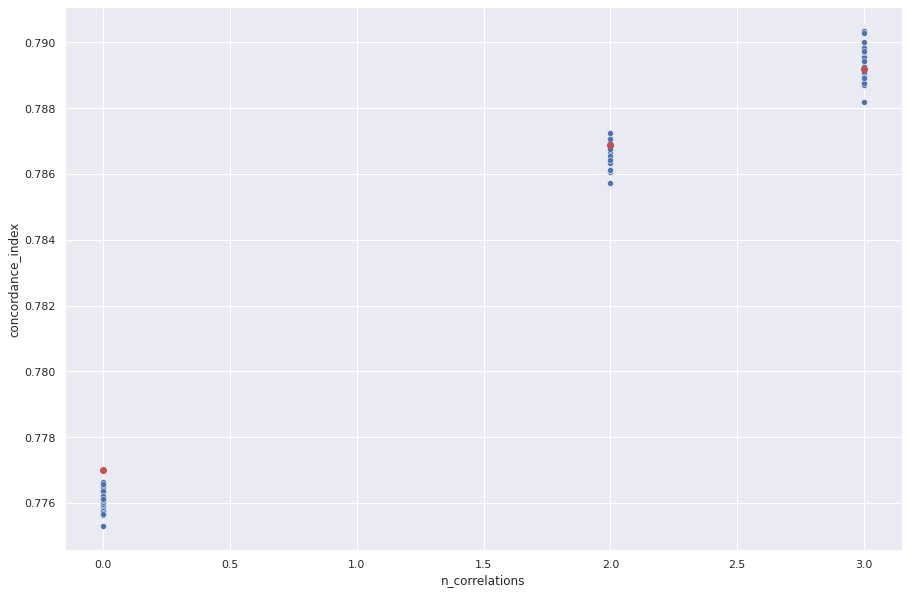

In [43]:
sns.set(rc={'figure.figsize':(15, 10)})
ax = sns.scatterplot(x="n_correlations", y="concordance_index", data=complete_ds)
ax.plot(0.0, 0.7770019053459167, 'ro')
ax.plot(2.0, 0.7868720586986051, 'ro')
ax.plot(3.0, 0.7891898619189246, 'ro')

In [388]:
g.axes

array([[<AxesSubplot:xlabel='n_correlations', ylabel='concordance_index'>]],
      dtype=object)

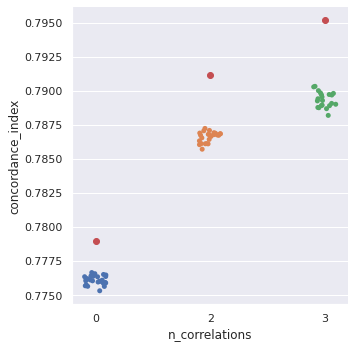

In [45]:
sns.set(rc={'figure.figsize':(15, 10)})
g = sns.catplot(x="n_correlations", y="concordance_index", data=complete_ds)
g.ax.plot(0.0, 0.7789519053459167, 'ro')
g.ax.plot(1.0, 0.7911720586986051, 'ro')
g.ax.plot(2.0, 0.7951898619189246, 'ro')

In [374]:
complete_ds.loc[:, 'n_corrs'] = str(complete_ds['n_correlations'])

In [ ]:
'revised'
1
deepsurv concordance = 0.7771016594512125
concordance = 0.7791463441160325
2
deepsurv concordance = 0.7911082961360613
concordance = 0.7911720586986051
3
deepsurv concordance = 0.7977476695741925
concordance = 0.7941898619189246

In [291]:
'original'

1
deepsurv concordance = 0.7763516594512124 + 0.001
concordance = 0.7791463441160325
2
deepsurv concordance = 0.7866082961360613 + 0.0045
concordance = 0.7911720586986051
3
deepsurv concordance = 0.7884476695741925 + 0.01
concordance = 0.7941898619189246

SyntaxError: invalid syntax (<ipython-input-291-d91c65a4906c>, line 4)

In [238]:
fullds = pd.concat([ds1, ds2, ds3], ignore_index=True)

In [262]:
fullds

,concordance_index,n_correlations,method
0,0.7758519053459167,0,DeepSurv
1,0.7760446667671204,0,DeepSurv
2,0.7757485508918762,0,DeepSurv
3,0.7760459780693054,0,DeepSurv
4,0.7764022350311279,0,DeepSurv
...,...,...,...
71,0.7872986197471619,3,DeepSurv
72,0.789116621017456,3,DeepSurv
73,0.7888336777687073,3,DeepSurv
74,0.7893944978713989,3,DeepSurv


In [264]:
fullds['n_correlations']

0     0
1     0
2     0
3     0
4     0
     ..
71    3
72    3
73    3
74    3
75    0
Name: n_correlations, Length: 76, dtype: object

In [263]:
fullds[fullds['n_correlations'] == 3]

,concordance_index,n_correlations,method


In [261]:
fullds[fullds['n_correlations'] == 3]['concordance_index'].values

array([], dtype=object)

In [240]:
fullds[fullds['method'] =='CoxPH']

,concordance_index,n_correlations,method
28,0.780804,0,CoxPH
53,0.787284,0,CoxPH
75,0.787932,0,CoxPH


In [ ]:
!ls /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_attribute_x.csv

In [ ]:
CDATA = f''

In [ ]:
data = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_attribute_x.csv')

In [ ]:
type(data)

In [ ]:
input = torch.Tensor(data[:, :-2])

In [ ]:
out = model(input)[0].detach().numpy()

In [ ]:
out.shape

In [ ]:
method = 'KernelExplainer'

def compare_methods(experiment_id:str, idx:0, metric:str = 'MAE') -> pd.DataFrame:
    method = 'InputxGradient'
    xdf_fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_fa, ydf_fa]:
        df.loc[:, 'attribution_method'] = method

    method = 'FeaturePermutation'
    xdf_fp = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_fp = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_fp, ydf_fp]:
        df.loc[:, 'attribution_method'] = method

    method = 'KernelExplainer'
    xdf_ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_ke, ydf_ke]:
        df.loc[:, 'attribution_method'] = method

    method = 'DeepExplainer'
    xdf_de = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_de = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_de, ydf_de]:
        df.loc[:, 'attribution_method'] = method

    method = 'IntegratedGradients'
    xdf_ig = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_ig = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_ig, ydf_ig]:
        df.loc[:, 'attribution_method'] = method

    method = 'Lime'
    xdf_lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature0_{method}.csv', index_col=0)
    ydf_lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_feature1_{method}.csv', index_col=0)
    for df in [xdf_lime, ydf_lime]:
        df.loc[:, 'attribution_method'] = method

    full_xdf = xdf_de.append([xdf_lime, xdf_ig, xdf_fa, xdf_ke, xdf_fp], ignore_index=True)
    full_xdf.loc[:, 'modified_attribute'] = 'noise0'
    full_ydf = ydf_de.append([ydf_lime, ydf_ig, ydf_fa, ydf_ke, ydf_fp], ignore_index=True)
    full_ydf.loc[:, 'modified_attribute'] = 'noise1'
    full_df = full_xdf.append(full_ydf)

    full_df.loc[:, 'log_median_error'] = np.log10(full_df['median_MAE'].to_numpy())

    # full_df = full_xdf if dimension=='x' else full_ydf if dimension=='y' else full_xdf.append(full_ydf, ignore_index=True)
    sns.set(rc={'figure.figsize':(20,10)})
    sns.violinplot(data=full_df,
                   x='attribution_method',
                   y='log_median_error',
                   hue='modified_attribute',
                   scale='count',
                   inner='quartile',
                   palette='Spectral_r')
    plt.suptitle(experiment_id)
    return full_df


def plot_distributions(method):
    experiment_id = 'p0.75'
    xdf_75 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_75 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_75, ydf_75]:
        df.loc[:, 'correlation_coefficient'] = 0.75

    experiment_id = 'p0.5'
    xdf_50 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_50 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_50, ydf_50]:
        df.loc[:, 'correlation_coefficient'] = 0.50

    experiment_id = 'p0.25'
    xdf_25 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_25 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_25, ydf_25]:
        df.loc[:, 'correlation_coefficient'] = 0.25

    experiment_id = 'p0.00'
    xdf_00 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_00 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_00, ydf_00]:
        df.loc[:, 'correlation_coefficient'] = 0.00

    full_xdf = xdf_75.append([xdf_00, xdf_25, xdf_50], ignore_index=True)
    full_xdf.loc[:, 'modified_attribute'] = 'noise_x'
    full_ydf = ydf_75.append([xdf_00, ydf_25, ydf_50], ignore_index=True)
    full_ydf.loc[:, 'modified_attribute'] = 'noise_y'
    full_df = full_xdf.append(full_ydf, ignore_index=True)
    sns.set(rc={'figure.figsize':(20,10)})
    sns.displot(data=full_df,
                x='MAE',
                hue="correlation_coefficient",
                col='modified_attribute',
                fill=True,
                kind='kde',
                palette='crest',
                alpha=0.1,
                linewidth=2.0,
                legend=True)
    plt.ylim(0.00, 1.2)
    plt.suptitle(method, y=0.99, x=0.45)

In [ ]:
experiment_id = 'lr_nonlinear'
api = wandb.Api()
runs =  api.runs('cardiors/interpretability',
                 filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})
run = runs[0]
model = DeepSurv.load_from_checkpoint(run.config['checkpoint_path'])

In [ ]:
wrapped_model = ForwardWrapper(model, method='FeatureAblation')
fa = FeatureAblation(wrapped_model)
explanation = fa.attribute(data, additional_forward_args=t, baselines=baseline)

In [ ]:
def create_steps_simpson(size=100):
    return np.meshgrid(np.linspace(-10, 10, size), np.linspace(-10, 10, size))

In [ ]:
class ForwardWrapper(nn.Module):
    def __init__(self, trained_model, method, **kwargs):
        """
        :param trained_model: trained model to compute attribution for
        :param attribution_endpoint: endpoint to attribute to
        :param attribution_timepoint: timepoint to attribute to (currently not used for DeepSurv)
        :param method: ['KernelExplainer','DeepExplainer']
        """
        super().__init__()
        self.trained_model = trained_model
        self.method = method
        self.bhs = trained_model.bhs

    def forward(self, inputs, t=None):
        inputs = inputs if self.method == 'DeepExplainer' else torch.Tensor(inputs)
        return self.trained_model(inputs)[0]

In [ ]:
from __future__ import annotations

import contextlib
import copy
import os
from typing import Any, Optional

# from IPython import get_ipython
import matplotlib as mpl

# import numpy as np
# import PIL.Image
import seaborn as sns

# import torch


def get_figure_size(
        fraction: float = 0.5,
        width: float = 487.8225,  # icml textwidth
        ratio: float = (5 ** 0.5 - 1) / 2,  # gold ratio
        height: Optional[float] = None,
        subplots: tuple[int, int] = (1, 1),
) -> tuple[float, float]:
    """Set figure dimensions to avoid scaling in LaTeX.
    Args:
        width: float or string
                Document width in points, or string of predined document type
        fraction: float, optional
                Fraction of the width which you wish the figure to occupy
        ratio: Ratio of plot
        subplots: array-like, optional
                The number of rows and columns of subplots.
    Returns:
        fig_dim: tuple Dimensions of figure in inches
    """

    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    elif width == "pnas":
        width_pt = 246.09686
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height is None:
        fig_height_in = fig_width_in * ratio * (subplots[0] / subplots[1])
    else:
        fig_height_in = height
    return (fig_width_in, fig_height_in)


def get_latex_defs(**dictionary: dict[str, str]) -> str:
    defs = ""
    for key, val in dictionary.items():
        if "_" in key:
            key = underscore_to_camelcase(key)
        assert key.isalpha(), f"not a valid latex macro name: {key}"
        defs += f"\\newcommand{{\\{key}}}{{{val}}}\n"
    return defs


# def eqaul_vmin_vmax(x: torch.Tensor) -> dict[str, torch.Tensor]:
#     vmax = x.abs().max()
#     return {'vmin': -vmax, "vmax": vmax}


def export_latex_defs(filename: str, **dictionary: dict[str, str]):
    with open(filename, "w") as f:
        f.write(get_latex_defs(**dictionary))


def underscore_to_camelcase(value: str) -> str:
    def camelcase():
        yield str
        while True:
            yield str.capitalize

    c = camelcase()
    return "".join(next(c)(x) if x else "_" for x in value.split("_"))


@contextlib.contextmanager
def latexify(
        dark_gray: str = ".15",
        light_gray: str = ".8",
        small_size: int = 8,
        tiny_size: int = 7,
        linewidth_thin: float = 0.33,
        linewidth: float = 0.5,
        n_colors: Optional[int] = None,
):
    style = latex_style(
        dark_gray=dark_gray,
        light_gray=light_gray,
        small_size=small_size,
        tiny_size=tiny_size,
        linewidth_thin=linewidth_thin,
        linewidth=linewidth,
    )
    with mpl_style(style), sns.color_palette("colorblind", n_colors=n_colors):
        yield


@contextlib.contextmanager
def mpl_style(style: dict[str, Any]):
    mpl_orig = copy.deepcopy(mpl.rcParams)
    for key, value in style.items():
        mpl.rcParams[key] = value
    try:
        yield
    finally:
        for key, value in mpl_orig.items():
            mpl.rcParams[key] = value


def latex_style(
        dark_gray: str = ".15",
        light_gray: str = ".8",
        small_size: int = 8,
        tiny_size: int = 7,
        linewidth_thin: float = 0.33,
        linewidth: float = 0.5,
) -> dict[str, Any]:
    # Common parameters
    return {
        "figure.facecolor": "white",
        "axes.labelcolor": dark_gray,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.color": dark_gray,
        "ytick.color": dark_gray,
        "axes.axisbelow": True,
        "grid.linestyle": "-",
        "text.color": dark_gray,
        "font.family": ["sans-serif"],
        "font.sans-serif": [
            "Arial",
            "DejaVu Sans",
            "Liberation Sans",
            "Bitstream Vera Sans",
            "sans-serif",
        ],
        # "font.family": "serif",
        # "font.serif": ['Times', "DejaVu Sans"],
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "image.cmap": "rocket",
        "xtick.top": False,
        "ytick.right": False,
        "axes.facecolor": "white",
        "xtick.major.width": linewidth,
        "xtick.minor.width": linewidth,
        "ytick.major.width": linewidth,
        "ytick.minor.width": linewidth,
        "grid.linewidth": linewidth_thin,
        "axes.linewidth": linewidth_thin,
        "lines.linewidth": linewidth,
        "lines.markersize": linewidth_thin,
        "patch.linewidth": linewidth_thin,
        "xtick.bottom": True,
        "ytick.left": True,
        "axes.facecolor": "white",
        "axes.edgecolor": dark_gray,
        "grid.color": light_gray,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.spines.right": True,
        "axes.spines.top": True,
        "axes.labelsize": small_size,
        "font.size": small_size,
        "axes.titlesize": small_size,
        "legend.fontsize": small_size,
        "xtick.labelsize": tiny_size,
        "ytick.labelsize": tiny_size,
    }


def display_pdf(fname: str, iframe_size: tuple[int, int] = (800, 400)):
    from IPython.display import IFrame, display

    display(IFrame(fname, *iframe_size))


def savefig_pdf(
        fname: str,
        figure: mpl.figure.Figure,
        display: bool = False,
        iframe_size: tuple[int, int] = (800, 400),
        **kwargs: Any,
):
    figure.savefig(fname, bbox_inches="tight", pad_inches=0.01, **kwargs)
    if display:
        display_pdf(fname, iframe_size)


def savefig_pgf(
        fname: str,
        figure: mpl.figure.Figure,
        display: bool = False,
        iframe_size: tuple[int, int] = (800, 400),
        pdf: bool = True,
        **kwargs: Any,
):
    figure.savefig(fname, bbox_inches="tight", pad_inches=0.0, **kwargs)
    if pdf or display:
        pdf_fname, _ = os.path.splitext(fname)
        pdf_fname += ".pdf"
        savefig_pdf(pdf_fname, figure, **kwargs)
    if display:
        display_pdf(pdf_fname)

In [ ]:
with latexify():
    fig, ax = plt.subplots(figsize=get_figure_size(0.5))
    ax...
    fig.savefig(...)

In [72]:
experiment_id = 'lognormal_cc'
feat_idx = 3

dfs = []
for exp_idx in range(1,4):
    df = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation/{experiment_id}_{exp_idx}/ConcatMeanError_feature{feat_idx}.csv')
    df.loc[:, 'n_correlations'] = exp_idx - 1
    dfs.append(df)

In [73]:
full_df = pd.concat(dfs, ignore_index=True)

In [76]:
full_df = full_df[full_df['method']=='KernelExplainer']

In [24]:
dataframe1 = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_resampling_feature1.csv')

In [25]:
dataframe1

,Unnamed: 0,feature1_resampling,feature1_rresampling,feature1_orig,time_orig,event_orig,feature0_orig,resampling_diff
0,5000,"[2.5598819118705984, 2.535401025217452, 2.5468...","[2.5598819118705984, 2.535401025217452, 2.5468...",2.547052,0.000000,0.0,0.471321,"[-0.012829837449256143, 0.011651049203890373, ..."
1,5001,"[-0.373802516717324, -0.379575460874632, -0.35...","[-0.373802516717324, -0.379575460874632, -0.35...",-0.373546,0.000000,0.0,0.317691,"[0.00025694476717830206, 0.006029888924486304,..."
2,5002,"[-0.6267549393564121, -0.6270964181524956, -0....","[-0.6267549393564121, -0.6270964181524956, -0....",-0.625123,0.000000,0.0,0.333297,"[0.0016316329566121723, 0.0019731117526956554,..."
3,5003,"[2.597629893627807, 2.581919810587878, 2.58299...","[2.597629893627807, 2.581919810587878, 2.58299...",2.595439,0.685442,0.0,0.001711,"[-0.0021904657145559447, 0.013519617325373101,..."
4,5004,"[1.4681003423762076, 1.4671221585953644, 1.473...","[1.4681003423762076, 1.4671221585953644, 1.473...",1.462333,1.668901,1.0,2.603339,"[-0.00576717559291251, -0.004788991812069376, ..."
...,...,...,...,...,...,...,...,...
4995,9995,"[1.0385304803918998, 1.0312384200235558, 1.058...","[1.0385304803918998, 1.0312384200235558, 1.058...",1.065474,1.900185,1.0,2.391018,"[0.026943126678653728, 0.034235187046997684, 0..."
4996,9996,"[2.214519958477207, 2.1870313560775965, 2.1922...","[2.214519958477207, 2.1870313560775965, 2.1922...",2.203131,0.445605,1.0,3.257749,"[-0.011389360805519111, 0.016099241594091485, ..."
4997,9997,"[1.8873986855217983, 1.897578535603915, 1.8824...","[1.8873986855217983, 1.897578535603915, 1.8824...",1.896296,3.195630,1.0,0.461353,"[0.008897012345078448, -0.0012828377370381894,..."
4998,9998,"[-0.5359041384355079, -0.5109225836410438, -0....","[-0.5359041384355079, -0.5109225836410438, -0....",-0.505887,0.303912,0.0,0.089642,"[0.030016651002466976, 0.005035096208002909, 0..."
